In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, MaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
import nltk
from nltk import word_tokenize, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import files
uploaded = files.upload()

Saving FinancialSentiment.csv to FinancialSentiment.csv


In [3]:
data = pd.read_csv('FinancialSentiment.csv', 
                   header = None, encoding="ISO-8859-1")
data.columns = ['Label', 'Text']
data.head()

,Label,Text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
data.Label.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [5]:
data.shape

(4846, 2)

In [6]:
pos = []
neg = []
neut = []
for l in data.Label:
    if l == "neutral":
        pos.append(0)
        neg.append(0)
        neut.append(1)
    elif l == "positive":
        pos.append(1)
        neg.append(0)
        neut.append(0)
    elif l == "negative":
        pos.append(0)
        neg.append(1)
        neut.append(0)

In [7]:
data['Pos']= pos
data['Neg']= neg
data['Neut'] = neut

In [8]:
data.head()

,Label,Text,Pos,Neg,Neut
0,neutral,"According to Gran , the company has no plans t...",0,0,1
1,neutral,Technopolis plans to develop in stages an area...,0,0,1
2,negative,The international electronic industry company ...,0,1,0
3,positive,With the new production plant the company woul...,1,0,0
4,positive,According to the company 's updated strategy f...,1,0,0


**Clean Data**

In [9]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [10]:
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [11]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [12]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [13]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [14]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [15]:
result = [' '.join(sen) for sen in filtered_words]

In [16]:
data['Text_Final'] = result

In [17]:
data['tokens'] = filtered_words

In [18]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg', 'Neut']]

In [19]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg,Neut
0,according gran company plans move production r...,"[according, gran, company, plans, move, produc...",neutral,0,0,1
1,technopolis plans develop stages area less 100...,"[technopolis, plans, develop, stages, area, le...",neutral,0,0,1
2,international electronic industry company elco...,"[international, electronic, industry, company,...",negative,0,1,0
3,new production plant company would increase ca...,"[new, production, plant, company, would, incre...",positive,1,0,0


**Split data**

In [20]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)
data_test, data_validate = train_test_split(data_test, test_size=0.5, random_state=1)
print(data_train)

                                             Text_Final  ... Neut
432   russia raisio food division home market stretc...  ...    1
3071  operators need learn use one device multiple l...  ...    1
289   company expects net sales first half 2008 reac...  ...    0
2588  bridge 12 km long located anasmotet road e20 n...  ...    1
4121  nokia capcom announced resident evil degenerat...  ...    1
...                                                 ...  ...  ...
4426  currency effect 30 pct 20 mln euro 313 mln neg...  ...    0
466   lidskoe pivo investment program foresees integ...  ...    0
3092  products include consumer electronics devices ...  ...    1
3772         bridge part highway 14 development project  ...    1
860   adp news oct 1 2008 finnish consulting enginee...  ...    0

[3876 rows x 6 columns]


**Google word2vec**

In [21]:
word2vec = models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [22]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

X_train = np.zeros((data_train.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
X_validate = np.zeros((data_validate.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
X_test = np.zeros((data_test.shape[0], MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))

index = 0
for line in data_train.Text_Final:
  wordId = 0
  for word in line.split():
    if word in word2vec:
      X_train[index, wordId] = word2vec[word]
    else:
      X_train[index, wordId] = np.random.rand(300)
    wordId += 1
  index += 1

index = 0
for line in data_validate.Text_Final:
  wordId = 0
  for word in line.split():
    if word in word2vec:
      X_validate[index, wordId] = word2vec[word]
    else:
      X_validate[index, wordId] = np.random.rand(300)
    wordId += 1
  index += 1

index = 0
for line in data_test.Text_Final:
  wordId = 0
  for word in line.split():
    if word in word2vec:
      X_test[index, wordId] = word2vec[word]
    else:
      X_test[index, wordId] = np.random.rand(300)
    wordId += 1
  index += 1

**Define CNN**

In [28]:
model = Sequential()
model.add(Dropout(0.3, input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Conv1D(input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM), filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.04), bias_regularizer=l2(0.04)))
model.add(Dropout(0.2)) 
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.04), bias_regularizer=l2(0.4)))

print(model.summary())

early_stopping = EarlyStopping(min_delta = 0.0001, monitor='val_loss', patience = 3, restore_best_weights=True)
callback = [early_stopping]

adam = Adam(learning_rate=0.00025)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_3 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 128)           192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 19, 64)            41024     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 5, 32)             10272     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)              

In [29]:
y_train = pd.get_dummies(data_train['Label']).values
y_validate = pd.get_dummies(data_validate['Label']).values
print(y_train)

[[0 1 0]
 [0 1 0]
 [0 0 1]
 ...
 [0 1 0]
 [0 1 0]
 [0 0 1]]


**Train CNN**

In [30]:
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_validate, y_validate), shuffle=True, batch_size=32, callbacks=callback)

Train on 3876 samples, validate on 485 samples
Epoch 1/35
3876/3876 [==============================] - 5s 1ms/step - loss: 5.4557 - accuracy: 0.5753 - val_loss: 4.1169 - val_accuracy: 0.6103
Epoch 2/35
3876/3876 [==============================] - 5s 1ms/step - loss: 3.2866 - accuracy: 0.6091 - val_loss: 2.5492 - val_accuracy: 0.6536
Epoch 3/35
3876/3876 [==============================] - 5s 1ms/step - loss: 2.1099 - accuracy: 0.6300 - val_loss: 1.7109 - val_accuracy: 0.6619
Epoch 4/35
3876/3876 [==============================] - 5s 1ms/step - loss: 1.4689 - accuracy: 0.6540 - val_loss: 1.2661 - val_accuracy: 0.6763
Epoch 5/35
3876/3876 [==============================] - 5s 1ms/step - loss: 1.1382 - accuracy: 0.6677 - val_loss: 1.0794 - val_accuracy: 0.6495
Epoch 6/35
3876/3876 [==============================] - 5s 1ms/step - loss: 0.9532 - accuracy: 0.6762 - val_loss: 0.9303 - val_accuracy: 0.6680
Epoch 7/35
3876/3876 [==============================] - 5s 1ms/step - loss: 0.8268 - accu

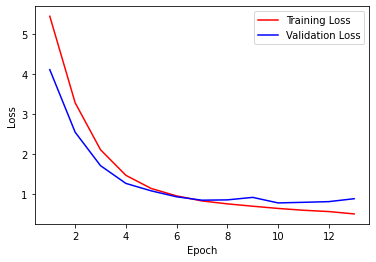

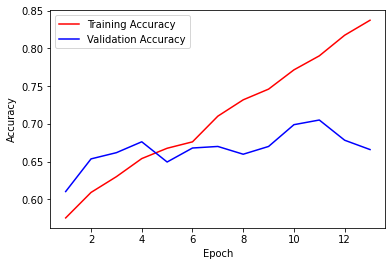

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'r-')
plt.plot(epochs, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epochs, history.history['accuracy'], 'r-')
plt.plot(epochs, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

**Test**

In [32]:
y_test = pd.get_dummies(data_test['Label']).values

loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

485/485 [==============================] - 0s 418us/step
Test Accuracy: 70.103091


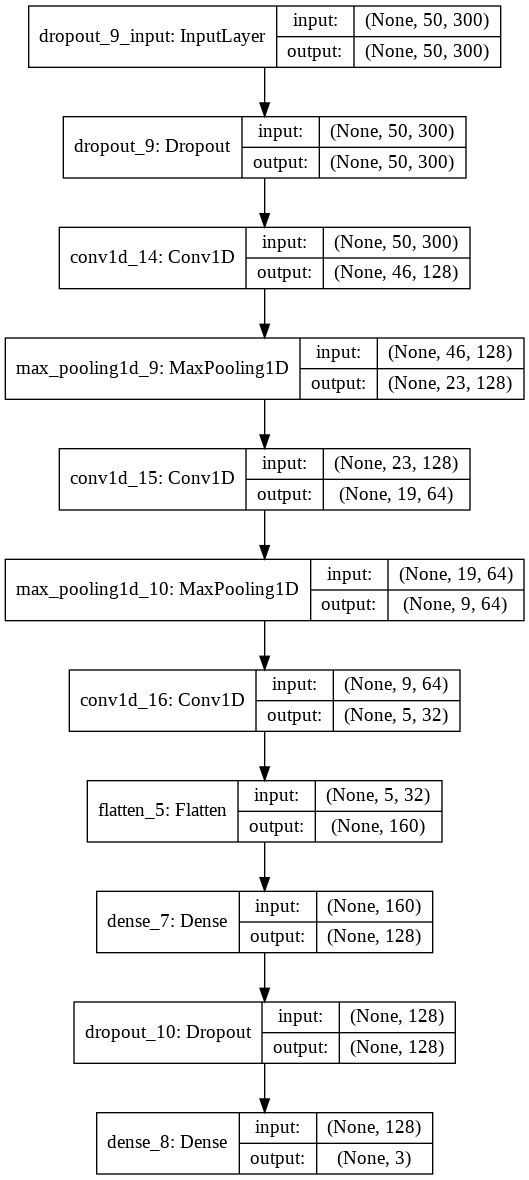

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)